# 预测以及策略

## 预测部分

In [29]:
# 导入所需要的库
from math import sin
import backtrader as bt
import matplotlib.pyplot as plt
import akshare as ak
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import math
import pandas as pd 
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from joblib import dump, load
# %%

from tensorflow import keras

from joblib import dump, load
from datetime import datetime

In [30]:
def getTrain(stock,train_ratio=0.5,validation_ratio=0.2,features=range(0,4)):
    stock.dropna()
    x=stock.iloc[:-1,features].values
    y=stock["close"].values[1:].reshape(-1,1)

    x_scalar=preprocessing.StandardScaler()
    y_scalar=preprocessing.StandardScaler()

    train_ends=math.floor(x.shape[0]*train_ratio)
    validation_ends=train_ends+1+math.floor(x.shape[0]*validation_ratio)

    x_train=x_scalar.fit_transform(x[0:train_ends,:])
    y_train=y_scalar.fit_transform(y[0:train_ends]).reshape(-1)

    x_validation=x_scalar.transform(x[train_ends:validation_ends,:])
    y_validation=y_scalar.transform(y[train_ends:validation_ends]).reshape(-1)

    x_test=x_scalar.transform(x[validation_ends:,:])
    y_test=y_scalar.transform(y[validation_ends:]).reshape(-1)
    return x_train,y_train,x_validation,y_validation,x_test,y_test,x_scalar,y_scalar




In [31]:
# 数据切片
def slice_time_series(x,y,win_size):
    x_sliced=[]
    y_sliced=[]
    for t in range(len(x)-win_size):
        x_sliced.append(x[t:t+win_size])
        y_sliced.append(y[t+win_size-1])
    x_sliced=np.array(x_sliced)
    y_sliced=np.array(y_sliced)
    return x_sliced.reshape((-1,win_size,feature_size)),y_sliced

# 建立模型
def build_model(win_size,feature_size,hiden=20):
    i=Input(shape=(win_size,feature_size))
    x=LSTM(hiden)(i)
    x=Dense(1)(x)
    model=Model(i,x)
    model.compile(loss='mse',optimizer=Adam(lr=0.01))
    return model
def multi_step_predict(model,data,N=1,feature_size=1):
    y_hat=[]
    x_test_last=data
    for i in range(N):
        y_hat_s1=model.predict(x_test_last.reshape(1,-1,feature_size))[0,0]
        x_test_last=np.roll(x_test_last,-1)
        x_test_last[-1]=y_hat_s1
        y_hat.append(y_hat_s1)
    return y_hat

Epoch 1/80
21/21 [==============================] - 1s 30ms/step - loss: 0.1331 - val_loss: 0.0150
Epoch 2/80
21/21 [==============================] - 0s 13ms/step - loss: 0.0179 - val_loss: 0.0063
Epoch 3/80
21/21 [==============================] - 0s 14ms/step - loss: 0.0133 - val_loss: 0.0086
Epoch 4/80
21/21 [==============================] - 0s 13ms/step - loss: 0.0123 - val_loss: 0.0056
Epoch 5/80
21/21 [==============================] - 0s 13ms/step - loss: 0.0115 - val_loss: 0.0054
Epoch 6/80
21/21 [==============================] - 0s 13ms/step - loss: 0.0110 - val_loss: 0.0073
Epoch 7/80
21/21 [==============================] - 0s 14ms/step - loss: 0.0110 - val_loss: 0.0050
Epoch 8/80
21/21 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 0.0049
Epoch 9/80
21/21 [==============================] - 0s 14ms/step - loss: 0.0102 - val_loss: 0.0053
Epoch 10/80
21/21 [==============================] - 0s 14ms/step - loss: 0.0101 - val_loss: 0.0049
Epoch 11/

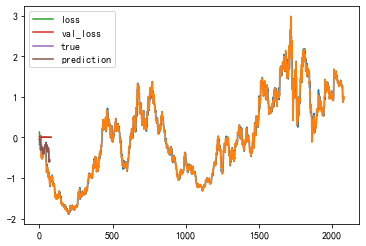

In [40]:
# 选择一组数据
data = ak.stock_zh_a_daily(symbol="sh600418",adjust="hfq")
stock_hfq_df = data['2008-01-01':'2018-6-30']
x_train,y_train,x_validation,y_validation,x_test,y_test,x_scalar,y_scalar=getTrain(
    stock_hfq_df,train_ratio=0.85,validation_ratio=0.1,features=range(0,4))
plt.plot(x_train[:,0])
plt.plot(y_train[:])
win_size=50
feature_size=x_train.shape[1]
x_train,y_train=slice_time_series(x_train,y_train,win_size)
x_validation,y_validation=slice_time_series(x_validation,y_validation,win_size)
x_test,y_test=slice_time_series(x_test,y_test,win_size)

model=build_model(win_size,feature_size,hiden=30)
# 进行训练
result=model.fit(x_train,y_train,
    batch_size=100,
    epochs=80,
    validation_data=(x_validation,y_validation))
# 画图
plt.plot(result.history['loss'],label="loss")
plt.plot(result.history['val_loss'],label="val_loss")
plt.legend()

y_hat=model.predict(x_test)
plt.plot(y_test,label='true')
plt.plot(y_hat,label='prediction')
plt.legend()



## 策略

In [51]:
class MyStrategy(bt.Strategy):
   
    params = (("maperiod", 20),('printlog',False),)  # 全局设定交易策略的参数
    model=0
    x_scalar=0
    y_scalar=0
    
    
    def __init__(self):

        self.data_close = self.datas[0].close  
        # 初始化交易指令、买卖价格和手续费
        self.order = None
        self.buy_price = None
        self.buy_comm = None

        self.win_size=50
        self.feature_size=4
        self.x_last=np.zeros((self.win_size,self.feature_size))
        self.days_elapsed=0
        # 添加移动均线指标
    

    def next(self):

        future=3
        self.days_elapsed+=1
        self.x_last=np.roll(self.x_last,-1)
        self.x_last[-1]=np.array([self.data.open[0],self.data.high[0],self.data.low[0],self.data.close][0])

        if self.days_elapsed<self.win_size:
            return
        
        scaled_x=x_scalar.transform(self.x_last)
        y_hat=multi_step_predict(model,scaled_x,N=future,feature_size=self.feature_size)

        y=y_scalar.transform(np.array(self.data.close[0]).reshape(1,1))[0,0]

        buy_margin=0.03
        sell_margin=-0.01
        if self.order:  
            return
        # 检查是否持仓
        if not self.position:  
            if y_hat[-1] > (1+buy_margin)*y:  # 执行买入条件判断：收盘价格上涨突破20日均线
                self.order = self.buy(size=15000) 
        else:
            if y_hat[-1] < (1+sell_margin)*y:  # 执行卖出条件判断：收盘价格跌破20日均线
                self.order = self.sell(size=15000)  
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
       
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入:\n价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}')
            self.bar_executed = len(self) 
        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None
    #记录交易收益情况
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')
    def stop(self):
        self.log('(MA均线： %2d日) 期末总资金 %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)



In [52]:
# 策略及回测
stock_hfq_df = ak.stock_zh_a_daily(symbol="sh600418", adjust="hfq") 
MyStrategy.model=model
MyStrategy.x_scalar=x_scalar
MyStrategy.y_scalar=y_scalar

cerebro = bt.Cerebro()  
start_date = datetime(2018, 7, 1)  
end_date = datetime(2020, 7, 1)  
data = bt.feeds.PandasData(dataname=stock_hfq_df, fromdate=start_date, todate=end_date)  
cerebro.adddata(data)  
cerebro.addstrategy(MyStrategy,maperiod=20,printlog=True)  
start_cash = 1000000
cerebro.broker.setcash(start_cash)  
cerebro.broker.setcommission(commission=0.002)  # 设置交易手续费为 0.2%
cerebro.run()  

port_value = cerebro.broker.getvalue()  
pnl = port_value - start_cash  

print(f"初始资金: {start_cash}\n回测期间：{start_date.strftime('%Y%m%d')}:{end_date.strftime('%Y%m%d')}")
print(f"总资金: {round(port_value, 2)}")
print(f"净收益: {round(pnl, 2)}")


2018-09-10,买入:
价格:34.969812187040645,                成本:524547.1828056097,                手续费:1049.0943656112195
2018-09-14,卖出:
价格：39.72859075269979,                成本: 524547.1828056097,                手续费1191.8577225809936
2018-09-14,策略收益：
毛收益 71381.68, 净收益 69140.73
2018-09-17,买入:
价格:36.33976359230616,                成本:545096.4538845924,                手续费:1090.1929077691848
2018-09-18,卖出:
价格：35.907147359064425,                成本: 545096.4538845924,                手续费1077.2144207719327
2018-09-18,策略收益：
毛收益 -6489.24, 净收益 -8656.65
2018-09-19,买入:
价格:36.41186629784645,                成本:546177.9944676968,                手续费:1092.3559889353935
2018-09-25,卖出:
价格：37.20499605878964,                成本: 546177.9944676968,                手续费1116.149881763689
2018-09-25,策略收益：
毛收益 11896.95, 净收益 9688.44
2018-09-26,买入:
价格:37.4934068809508,                成本:562401.103214262,                手续费:1124.802206428524
2018-10-08,卖出:
价格：36.55607170892703,                成本: 562401.103214262,              

2019-05-27,卖出:
价格：37.13289335324935,                成本: 577542.6713777229,                手续费1113.9868005974806
2019-05-27,策略收益：
毛收益 -20549.27, 净收益 -22818.34
2019-05-28,买入:
价格:38.358639347434284,                成本:575379.5902115143,                手续费:1150.7591804230285
2019-05-30,卖出:
价格：37.92602311419254,                成本: 575379.5902115143,                手续费1137.7806934257762
2019-05-30,策略收益：
毛收益 -6489.24, 净收益 -8777.78
2019-05-31,买入:
价格:38.2144339363537,                成本:573216.5090453055,                手续费:1146.433018090611
2019-06-12,卖出:
价格：37.4934068809508,                成本: 573216.5090453055,                手续费1124.802206428524
2019-06-12,策略收益：
毛收益 -10815.41, 净收益 -13086.64
2019-06-13,买入:
价格:37.27709876432993,                成本:559156.481464949,                手续费:1118.3129629298978
2019-06-14,卖出:
价格：37.42130417541051,                成本: 559156.481464949,                手续费1122.6391252623152
2019-06-14,策略收益：
毛收益 2163.08, 净收益 -77.87
2019-06-17,买入:
价格:36.84448253108819,        

2020-05-21,卖出:
价格：43.117417913093426,                成本: 548341.0756339055,                手续费1293.5225373928029
2020-05-21,策略收益：
毛收益 98420.19, 净收益 96029.99
2020-05-22,买入:
价格:45.35260178484241,                成本:680289.0267726362,                手续费:1360.5780535452725
2020-05-25,卖出:
价格：51.913947989008804,                成本: 680289.0267726362,                手续费1557.4184396702642
2020-05-25,策略收益：
毛收益 98420.19, 净收益 95502.20
2020-05-26,买入:
价格:45.35260178484241,                成本:680289.0267726362,                手续费:1360.5780535452725
2020-05-27,卖出:
价格：53.3560020998146,                成本: 680289.0267726362,                手续费1600.680062994438
2020-05-27,策略收益：
毛收益 120051.00, 净收益 117089.75
2020-05-28,买入:
价格:60.42206724276303,                成本:906331.0086414454,                手续费:1812.662017282891
2020-05-29,卖出:
价格：66.47869450814738,                成本: 906331.0086414454,                手续费1994.3608352444217
2020-05-29,策略收益：
毛收益 90849.41, 净收益 87042.39
2020-06-03,买入:
价格:62.8014565255926,    

在最后一行可以看到赚到了多少钱